The lightcurve of object 4450 8746 1072 12
shows some "messiness".
It stands out as the variable is quite periodic otherwise.
I want to use it as a test case for some final "healing" 
in an ad hoc way of the NGC 1333 data. There are enough bad outliers in the data at present that I don't wish to present the 

I want to investigate those specifics. For example..... is there ANY evidence that these blips are physical? How is the GRADE flags on these?

GRADE isn't catching this AT ALL. (or, at least one of them...)
Maybe that one is physical.
Cranking grade up to 96% might improve things... Or even 97. There are still gains.
Or - perhaps - if grade is below 97.5 AND there's a big divergence from both the next and prior data point, kill it. That is principled enough.

Weird.

Ad hoc it is.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pdb

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

In [3]:
from wuvars.plotting.lightcurve import simple_lc, simple_lc_brokenaxes, ngc1333_simple_lc_brokenaxes, ngc1333_simple_lc_scatter_brokenaxes
from wuvars.data import spreadsheet, photometry, quality_classes


In [4]:
# load the data

dat = photometry.group_wserv_v2(photometry.load_wserv_v2(7))
q = quality_classes.load_q(7)

Loading WSERV7 photometry data... DONE (elapsed time: 0.20s)


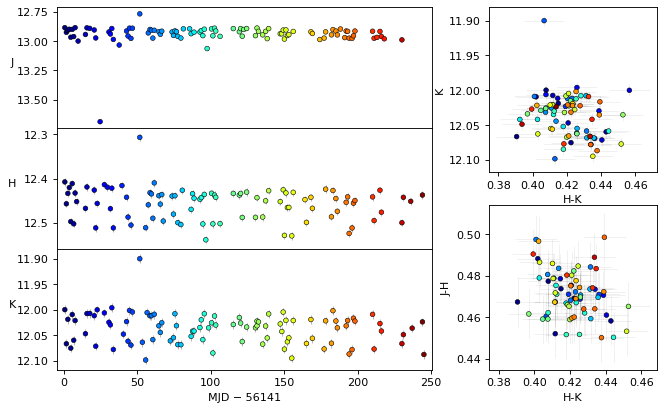

In [5]:
sid = 44508746107212

# plot the lc

fig_lc = ngc1333_simple_lc_scatter_brokenaxes(dat, sid, cmap='jet')



In [6]:
ngc1333_simple_lc_scatter_brokenaxes??

In [7]:
from wuvars.plotting.lightcurve_helpers import produce_xlims, orion_cmap
from brokenaxes import brokenaxes

def simple_lc_scatter_brokenaxes_grade(
    dg, sid, date_offset=None, pad=5, xlims=None, breaks=None, **kwargs
):
    # dg: astropy table that has been grouped by SOURCEID

    dat = dg.groups[dg.groups.keys["SOURCEID"] == sid]

    # set up data

    if date_offset is None:
        date_offset = np.floor(np.min(dat["MEANMJDOBS"]))
    date = dat["MEANMJDOBS"] - date_offset

    j = dat["JAPERMAG3"]
    h = dat["HAPERMAG3"]
    k = dat["KAPERMAG3"]

    j_e = dat["JAPERMAG3ERR"]
    h_e = dat["HAPERMAG3ERR"]
    k_e = dat["KAPERMAG3ERR"]
    
    j_grade = dat["JGRADE"]
    h_grade = dat["HGRADE"]
    k_grade = dat["KGRADE"]
    
    print("J GRADES: ", np.min(j_grade), np.max(j_grade))
    print("H GRADES: ", np.min(h_grade), np.max(h_grade))
    print("K GRADES: ", np.min(k_grade), np.max(k_grade))

    # set up plot
    # OUR brokenaxes changes will all go here
    # need:
    #   - how much MJD to subtract
    #   - where to put the breaks (+how many breaks)
    #   - ... that's p much it, right?

    fig = plt.figure(figsize=(10, 6), dpi=80, facecolor="w", edgecolor="k")

    gs0 = fig.add_gridspec(1, 2, width_ratios=[6, 3], wspace=0.2)
    gs_left = gs0[0].subgridspec(3, 1, hspace=0)
    gs_right = gs0[1].subgridspec(1, 2, width_ratios=(2, 0.075), wspace=0.15)
    gs01 = gs_right[0].subgridspec(2, 1)

    bax_kwargs = dict(despine=False, d=0.0075, tilt=60, wspace=0.04)

    # xlims = (
    #     (56848 - date_offset, 56900 - date_offset),
    #     (56920 - date_offset, 57080 - date_offset),
    #     (57200 - date_offset, 57250 - date_offset),
    # )

    # xlims = ((0, 30), (80, 225), (370,390))
    # xlims = [(0.0, 21.0), (84.0, 222.0), (377.0, 385.0)]
    if xlims is None:
        if breaks is None:
            # baked-in default since I was prototyping on IC348; possibly a bad default
            breaks = [50, 350]
        xlims = produce_xlims(date, breaks=breaks, pad=pad)
        # print(xlims)

    ax_j = brokenaxes(xlims=xlims, subplot_spec=gs_left[0, 0], **bax_kwargs)
    ax_h = brokenaxes(xlims=xlims, subplot_spec=gs_left[1, 0], **bax_kwargs)
    ax_k = brokenaxes(xlims=xlims, subplot_spec=gs_left[2, 0], **bax_kwargs)

    # Make the broken zones gray. (Uses some details from  )
    ax_j.big_ax.set_zorder(-100)
    ax_h.big_ax.set_zorder(-100)
    ax_k.big_ax.set_zorder(-100)
    ax_j.big_ax.set_facecolor("0.9")
    ax_h.big_ax.set_facecolor("0.9")
    ax_k.big_ax.set_facecolor("0.9")

    ax_khk = fig.add_subplot(gs01[0, 0])
    ax_jhk = fig.add_subplot(gs01[1, 0])

    # ax_cbar = fig.add_subplot(gs_right[1])

    ax_j.tick_params(labelbottom=False)
    ax_h.tick_params(labelbottom=False)

    # bottom = 0.1
    # height = 0.25
    # left = 0.075
    # width = 0.5

    # ax_k = fig.add_axes((left, bottom, width, height))
    # ax_h = fig.add_axes((left, bottom + 0.3, width, height), sharex=ax_k)
    # ax_j = fig.add_axes((left, bottom + 0.6, width, height), sharex=ax_k)

    # ax_jhk = fig.add_axes((0.65, bottom, 0.3, 0.375))
    # ax_khk = fig.add_axes((0.65, bottom + 0.475, 0.3, 0.375))

    fig.ax_k = ax_k
    fig.ax_j = ax_j
    fig.ax_h = ax_h
    fig.ax_jhk = ax_jhk
    fig.ax_khk = ax_khk

    sc_j = ax_j.scatter(
        date,
        j,
        c=j_grade,
        vmin=None,
        vmax=None,
        s=18,
        edgecolors="k",
        linewidths=0.5,
        **kwargs,
    )
    sc_h = ax_h.scatter(
        date,
        h,
        c=h_grade,
        vmin=None,
        vmax=None,
        s=18,
        edgecolors="k",
        linewidths=0.5,
        **kwargs,
    )
    sc_k = ax_k.scatter(
        date,
        k,
        c=k_grade,
        vmin=None,
        vmax=None,
        s=18,
        edgecolors="k",
        linewidths=0.5,
        **kwargs,
    )

    ax_j.errorbar(
        date,
        j,
        yerr=j_e,
        fmt="None",
        ecolor="k",
        ms=2,
        elinewidth=0.5,
        zorder=-1,
        alpha=0.5,
    )
    ax_h.errorbar(
        date,
        h,
        yerr=h_e,
        fmt="None",
        ecolor="k",
        ms=2,
        elinewidth=0.5,
        zorder=-1,
        alpha=0.5,
    )
    ax_k.errorbar(
        date,
        k,
        yerr=k_e,
        fmt="None",
        ecolor="k",
        ms=2,
        elinewidth=0.5,
        zorder=-1,
        alpha=0.5,
    )

    sc_jhk = ax_jhk.scatter(
        h - k,
        j - h,
        c=np.min((j_grade, h_grade, k_grade), axis=0),
        vmin=None,
        vmax=None,
        s=18,
        edgecolors="k",
        linewidths=0.5,
        **kwargs,
    )

    sc_khk = ax_khk.scatter(
        h - k,
        k,
        c=np.min((h_grade, k_grade), axis=0),
        vmin=None,
        vmax=None,
        s=18,
        edgecolors="k",
        linewidths=0.5,
        **kwargs,
    )

    ax_jhk.errorbar(
        h - k,
        j - h,
        xerr=(h_e ** 2 + k_e ** 2) ** 0.5,
        yerr=(h_e ** 2 + j_e ** 2) ** 0.5,
        fmt="None",
        ecolor="k",
        ms=2,
        elinewidth=0.5,
        zorder=-1,
        alpha=0.1,
    )

    ax_khk.errorbar(
        h - k,
        k,
        xerr=(h_e ** 2 + k_e ** 2) ** 0.5,
        yerr=k_e,
        fmt="None",
        ecolor="k",
        ms=2,
        elinewidth=0.5,
        zorder=-1,
        alpha=0.1,
    )

    # cbar = fig.colorbar(
    #     sc_j[0], cax=ax_cbar
    # )  # This should really be changed to the method

    ax_j.invert_yaxis()
    ax_h.invert_yaxis()
    ax_k.invert_yaxis()
    ax_khk.invert_yaxis()

    ax_j.set_ylabel("J", labelpad=40, fontdict={"rotation": "horizontal"})
    ax_h.set_ylabel("H", labelpad=40, fontdict={"rotation": "horizontal"})
    ax_k.set_ylabel("K", labelpad=40, fontdict={"rotation": "horizontal"})

    # \u2212 is a proper minus sign (better than the hyphen character `-`)
    ax_k.set_xlabel(f"MJD \u2212 {date_offset}", labelpad=20)
    # cbar.set_label(f"MJD \u2212 {date_offset}")

    ax_jhk.set_xlabel("H-K")
    ax_jhk.set_ylabel("J-H")  # , {'rotation':'horizontal'})
    ax_khk.set_xlabel("H-K")
    ax_khk.set_ylabel("K")  # , {'rotation':'horizontal'})
    
    plt.colorbar(sc_jhk)

    return fig

J GRADES:  0.0 1.0
H GRADES:  0.0 1.0
K GRADES:  0.0 1.0
J GRADES:  0.0 1.0
H GRADES:  0.0 1.0
K GRADES:  0.0 1.0
J GRADES:  0.0 1.0
H GRADES:  0.0 1.0
K GRADES:  0.0 1.0


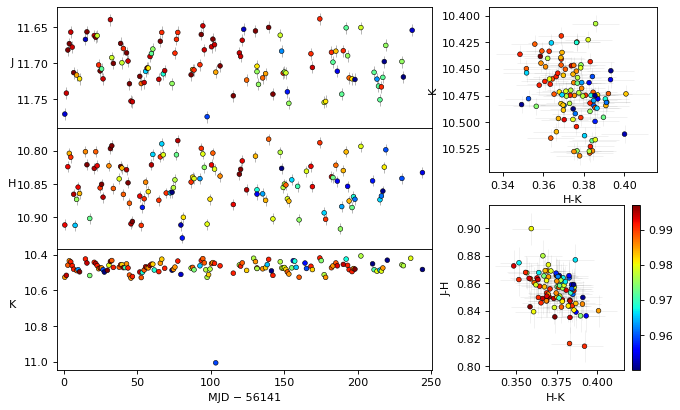

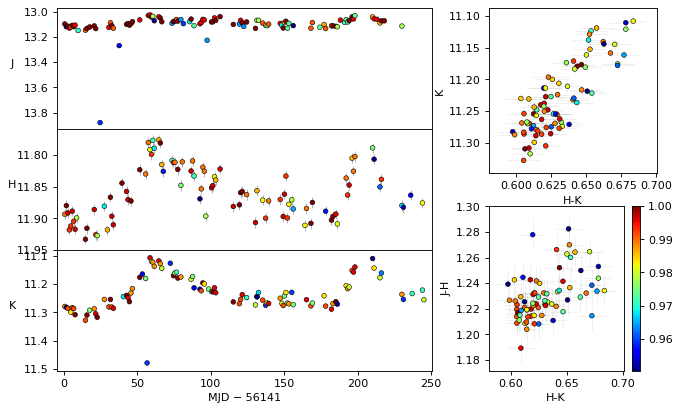

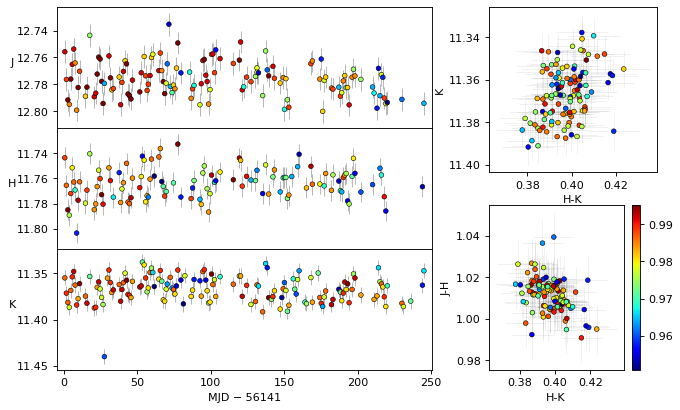

In [8]:
sid2 = 44508746127611
fig2 = simple_lc_scatter_brokenaxes_grade(dat, sid2, date_offset=56141, xlims=[(-5, 251.0)], cmap='jet')
sid3 = 44508746107259
fig3 = simple_lc_scatter_brokenaxes_grade(dat, sid3, date_offset=56141, xlims=[(-5, 251.0)], cmap='jet')
fig4 = simple_lc_scatter_brokenaxes_grade(dat, 44508746116310, date_offset=56141, xlims=[(-5, 251.0)], cmap='jet')


J GRADES:  0.0 1.0
H GRADES:  0.0 1.0
K GRADES:  0.0 1.0


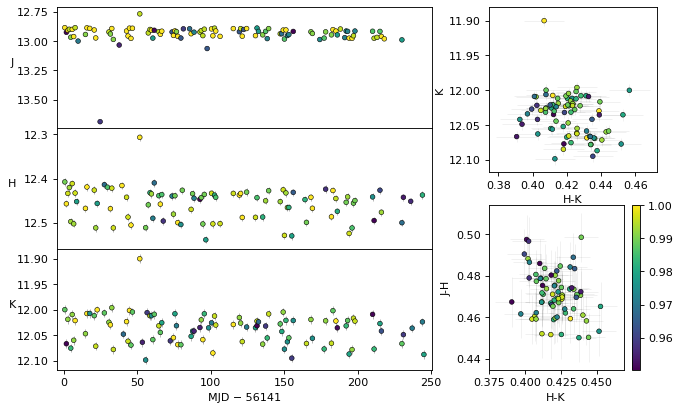

In [9]:
# pull up the tables and maybe color code the points by GRADE or some other metric

fig = simple_lc_scatter_brokenaxes_grade(dat, sid, date_offset=56141, xlims=[(-5, 251.0)])

In [10]:
left_diff = 2
right_diff = -1

diffs = np.array([left_diff, right_diff])
abs_diffs = np.array([np.abs(left_diff), np.abs(right_diff)])
diff_abs = min(abs_diffs)
diff_sgn = np.sign( diffs[diff_abs==abs_diffs] )[0]

In [11]:
abs_diffs, diff_abs, diff_sgn

(array([2, 1]), 1, -1)

In [12]:
diff_abs==abs_diffs

array([False,  True])

In [21]:
# let's prototype my closeness metric.

def calculate_diff(dat, sid, band="J", verbose=False):

    dt = dat.groups[dat.groups.keys["SOURCEID"] == sid]

    b_vals = dt[f'{band}APERMAG3']
    b_sigs = dt[f'{band}APERMAG3ERR']

    diff = np.zeros_like(b_vals)

    l = len(b_vals)

    for i in range(l):

        if verbose:
            print("i=", i)

        left_diff = np.nan
        right_diff = np.nan
        diff[i] = np.nan

        if not np.ma.is_masked(b_vals[i]):

            a_l = 1

            while (i-a_l) >= 0:

                left_diff = (b_vals[i-a_l] - b_vals[i]) / b_sigs[i]

                if verbose:
                    print("Left diff:", left_diff, "a_l = ", a_l)

                if i==8:
                    pdb.set_trace()

                if not np.ma.is_masked(left_diff):
                    if verbose:
                        print("  Breaking -  we accept left_diff")
                    break
                else:
                    if verbose:
                        print("  Not breaking - we don't accept left_diff")
                    a_l += 1
                    if verbose:
                        print("  a_l = ", a_l)
            if verbose:
                print("a_l: ", a_l, "i-a_l=", i-a_l)
                print("")

            a_r = 1

            while (i+a_r) < l:

                right_diff = (b_vals[i+a_r] - b_vals[i]) / b_sigs[i]

                if not np.ma.is_masked(right_diff):
                    print("Breaking")
                    break
                else:
                    print("Not breaking")
                    a_r += 1     
            if verbose:
                print("a_r: ", a_r, "i+a_r", i+a_r, "l=", l)

                print(left_diff, right_diff)

            try:
                diffs = np.array([left_diff, right_diff])
                abs_diffs = np.array([np.abs(left_diff), np.abs(right_diff)])
                diff_abs = min(abs_diffs)
                diff_sgn = np.sign( diffs[diff_abs==abs_diffs] )[0]

                diff[i] = diff_sgn * diff_abs
            except IndexError:
                diff[i] = np.nan
        else:
            if verbose:
                print(f"i={i}: {band}={j_vals[i]} is masked")

    #         if i>3:
    #             break
    return diff

In [104]:
# let's prototype my closeness metric.

def calculate_diffs(dat, sid, verbose=True):

    dt = dat.groups[dat.groups.keys["SOURCEID"] == sid]
    
    diffs_list = []
    
    for band in ["J", "H", "K"]:
        if verbose:
            print(f"Doing {band}")

        b_vals = dt[f'{band}APERMAG3']
        b_sigs = dt[f'{band}APERMAG3ERR']

        diff = np.zeros_like(b_vals)

        l = len(b_vals)

        for i in range(l):

            if verbose:
                print("i=", i)

            left_diff = np.nan
            right_diff = np.nan
            diff[i] = np.nan

            if not np.ma.is_masked(b_vals[i]):

                a_l = 1

                while (i-a_l) >= 0:

                    left_diff = (b_vals[i-a_l] - b_vals[i]) / b_sigs[i]

                    if verbose:
                        print("Left diff:", left_diff, "a_l = ", a_l)

                    if not np.ma.is_masked(left_diff):
                        if verbose:
                            print("  Breaking -  we accept left_diff")
                        break
                    else:
                        if verbose:
                            print("  Not breaking - we don't accept left_diff")
                        a_l += 1
                        if verbose:
                            print("  a_l = ", a_l)
                if verbose:
                    print("a_l: ", a_l, "i-a_l=", i-a_l)
                    print("")

                a_r = 1

                while (i+a_r) < l:

                    right_diff = (b_vals[i+a_r] - b_vals[i]) / b_sigs[i]

                    if not np.ma.is_masked(right_diff):
                        if verbose:
                            print("Breaking")
                        break
                    else:
                        if verbose:
                            print("Not breaking")
                        a_r += 1     
                if verbose:
                    print("a_r: ", a_r, "i+a_r", i+a_r, "l=", l)

                    print(left_diff, right_diff)

                try:
                    diffs = np.array([left_diff, right_diff])
                    abs_diffs = np.array([np.abs(left_diff), np.abs(right_diff)])
                    diff_abs = min(abs_diffs)
                    diff_sgn = np.sign( diffs[diff_abs==abs_diffs] )[0]

                    diff[i] = diff_sgn * diff_abs
                except IndexError:
                    diff[i] = np.nan
            else:
                if verbose:
                    print(f"i={i}: {band}={b_vals[i]} is masked")

        diffs_list.append(diff)
    return diffs_list

In [106]:
calculate_diffs(dat, sid, verbose=False)

[<MaskedColumn name='JAPERMAG3' dtype='float32' length=166>
        nan
 -2.0194223
 -1.0273886
  1.0287642
 -7.9850473
   7.299637
  -7.283057
   9.003369
        nan
        ...
        nan
        nan
 -1.0519242
        nan
        nan
        nan
        nan
        nan
        nan,
 <MaskedColumn name='HAPERMAG3' dtype='float32' length=166>
        nan
 -2.8334835
  -1.585543
  1.5852772
  -9.274089
  10.373943
  -8.380841
  2.3239634
  1.8390429
        ...
        nan
        nan
 -2.8428533
  1.0835217
 -1.0795771
        nan
        nan
  1.7055048
        nan,
 <MaskedColumn name='KAPERMAG3' dtype='float32' length=166>
        nan
 -5.7076545
  5.7316823
        nan
 -6.7641973
  6.0329757
 -4.6165133
  3.0787897
        nan
        ...
        nan
        nan
 -2.1097546
 -1.5109175
        nan
 -1.4720012
        nan
   1.479618
 -7.6258035]

In [22]:
calculate_diff(dat, sid)

Breaking
Breaking
Breaking
Breaking
Breaking
Breaking
Breaking
Not breaking
Breaking
Not breaking
Breaking
Breaking
Not breaking
Breaking
Breaking
Breaking
Not breaking
Not breaking
Breaking
Not breaking
Not breaking
Not breaking
Not breaking
Not breaking
Breaking
Breaking
Breaking
Breaking
Breaking
Not breaking
Not breaking
Not breaking
Not breaking
Breaking
Breaking
Breaking
Breaking
Breaking
Breaking
Not breaking
Not breaking
Not breaking
Not breaking
Not breaking
Breaking
Breaking
Breaking
Breaking
Breaking
Breaking
Breaking
Breaking
Not breaking
Not breaking
Not breaking
Not breaking
Not breaking
Not breaking
Breaking
Breaking
Breaking
Breaking
Breaking
Breaking
Not breaking
Breaking
Not breaking
Breaking
Breaking
Not breaking
Breaking
Breaking
Breaking
Breaking
Breaking
Not breaking
Breaking
Not breaking
Not breaking
Breaking
Breaking
Breaking
Breaking
Breaking
Not breaking
Breaking
Breaking
Breaking
Breaking
Breaking
Breaking
Not breaking
Not breaking
Breaking
Not breaking
Break

nan
-2.0194223
-1.0273886
1.0287642
-7.9850473
7.299637
-7.283057
9.003369
nan
...
nan


In [23]:
_20 == _22

masked_array(data=[False,  True,  True,  True,  True,  True,  True,  True,
                   False,  True, False,  True,  True, False,  True,  True,
                    True, False, False,  True, False, False, False, False,
                   False,  True,  True,  True,  True,  True, False, False,
                   False, False,  True,  True,  True,  True,  True,  True,
                   False, False, False, False, False,  True,  True,  True,
                    True,  True,  True,  True,  True, False, False, False,
                   False, False, False,  True,  True,  True,  True,  True,
                    True, False,  True, False,  True,  True, False,  True,
                    True,  True,  True,  True, False,  True, False, False,
                    True,  True,  True,  True,  True, False,  True,  True,
                    True,  True,  True,  True, False, False,  True, False,
                    True,  True,  True,  True,  True,  True, False, False,
                   False,

In [35]:
_29[2] == _20

masked_array(data=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False,

In [15]:
plt.plot(dt['MEANMJDOBS'] - 56141, diff, 'k.')

NameError: name 'dt' is not defined

In [ ]:
plt.plot(dt['MEANMJDOBS'] - 56141, diff, 'k.')

In [ ]:
diff_ = calculate_diff(dat, sid, verbose=True)
plt.plot(dt['MEANMJDOBS'] - 56141, diff_, 'k.')
# plt.plot(dt['JGRADE'], diff_, 'k.')

In [ ]:
plt.plot(dt['JGRADE'], diff_, 'k.')

In [ ]:
np.min(j_grade, h_grade, k_grade)

In [37]:
siddat = dat.groups[dat.groups.keys["SOURCEID"] == sid]


In [ ]:
weird_row = siddat['JAPERMAG3'] == np.nanmax(siddat['JAPERMAG3'])
weird_row_k = siddat['KAPERMAG3'] == np.nanmin(siddat['KAPERMAG3'])

In [ ]:
siddat[weird_row]

In [ ]:
siddat[weird_row_k]

In [ ]:
siddat['HGRADE']

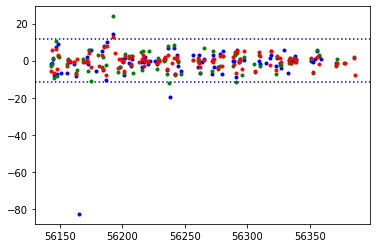

In [58]:
j_diff_rms = np.nanstd(_29[0])
j_diff_mean = np.nanmean(_29[0])
j_diff_mad = scipy.stats.median_abs_deviation(_29[0], nan_policy='omit')

h_diff_rms = np.nanstd(_29[1])
h_diff_mean = np.nanmean(_29[1])

plt.plot(siddat['MEANMJDOBS'], _29[0], 'b.')

# plt.axhline(j_diff_mean, color='b')
# plt.axhline(j_diff_rms, color='b')
# plt.axhline(-j_diff_rms, color='b')

plt.axhline(3 * 1.4826*j_diff_mad, color='b', linestyle=':')
plt.axhline(3 * 1.4826*-j_diff_mad, color='b', linestyle=':')

plt.plot(siddat['MEANMJDOBS'], _29[1], 'g.')

# plt.axhline(h_diff_mean, color='g')
# plt.axhline(h_diff_rms, color='g')
# plt.axhline(-h_diff_rms, color='g')

plt.plot(siddat['MEANMJDOBS'], _29[2], 'r.')

In [51]:
scipy.stats.median_abs_deviation()

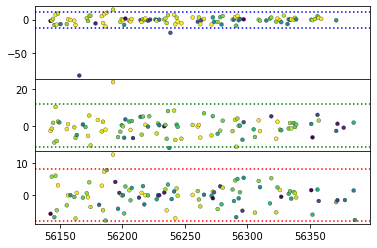

In [76]:
j_diff = _29[0]
h_diff = _29[1]
k_diff = _29[2]

fig, axes = plt.subplots(nrows=3, sharex=True)
fig.subplots_adjust(hspace=0)

j_diff_rms = np.nanstd(_29[0])
j_diff_mean = np.nanmean(_29[0])
j_diff_mad = scipy.stats.median_abs_deviation(_29[0], nan_policy='omit')

h_diff_rms = np.nanstd(_29[1])
h_diff_mean = np.nanmean(_29[1])
h_diff_mad = scipy.stats.median_abs_deviation(_29[1], nan_policy='omit')

k_diff_rms = np.nanstd(_29[2])
k_diff_mean = np.nanmean(_29[2])
k_diff_mad = scipy.stats.median_abs_deviation(_29[2], nan_policy='omit')


plt.sca(axes[0])

plt.scatter(siddat['MEANMJDOBS'], _29[0], c=siddat["JGRADE"], s=15, edgecolor='k', linewidth=0.25)

# plt.axhline(j_diff_mean, color='b')
# plt.axhline(j_diff_rms, color='b')
# plt.axhline(-j_diff_rms, color='b')

plt.axhline(3 * 1.4826*j_diff_mad, color='b', linestyle=':')
plt.axhline(3 * 1.4826*-j_diff_mad, color='b', linestyle=':')

# plt.plot(siddat['MEANMJDOBS'], _29[1], 'g.')

plt.sca(axes[1])

plt.scatter(siddat['MEANMJDOBS'], _29[1], c=siddat["HGRADE"], s=15, edgecolor='k', linewidth=0.25)

plt.axhline(3 * 1.4826*h_diff_mad, color='g', linestyle=':')
plt.axhline(3 * 1.4826*-h_diff_mad, color='g', linestyle=':')
# # plt.axhline(-h_diff_rms, color='g')

plt.sca(axes[2])

plt.scatter(siddat['MEANMJDOBS'], _29[2], c=siddat["KGRADE"], s=15, edgecolor='k', linewidth=0.25)

plt.axhline(3 * 1.4826*k_diff_mad, color='r', linestyle=':')
plt.axhline(3 * 1.4826*-k_diff_mad, color='r', linestyle=':')



In [93]:
k_mad = 1.4826
bands = ['J', "H", "K"]
diffs = {"J": j_diff, "H": h_diff, "K": k_diff}
mads = {"J": j_diff_mad, "H": h_diff_mad, "K": k_diff_mad}

for i in range(len(j_diff)):
    
    for b in range(len(bands)):
        b0 = bands[b]   # J, H, K
        b1 = bands[b-1] # K, J, H
        b2 = bands[b-2] # H, K, J
        
        this_datum = diffs[b0][i]
        this_grade = siddat[f"{b0}GRADE"][i]
        this_date = siddat["MEANMJDOBS"][i]
        
        if (np.abs(this_datum) > 3*k_mad*mads[b0]) and (this_grade < 0.98):
            print(f"Found an outlier! {b0}: {this_datum} and {this_grade}")
            print(f"  at date={this_date-56141:.1f} (i={i})")
#             print(f"  Found an outlier! {this_datum=} and {this_grade=}")

            if (diffs[b1][i] > 3*k_mad*mads[b1]) or (diffs[b2][i] > 3*k_mad*mads[b2]):
                print("*** But there are outliers in other bands at that time too. No flag. ***")
            
            

Found an outlier! J: -82.719482421875 and 0.9586206674575806
  at date=24.6 (i=19)
Found an outlier! H: -12.2584810256958 and 0.97826087474823
  at date=96.6 (i=76)
Found an outlier! J: -19.561403274536133 and 0.9641255736351013
  at date=97.5 (i=77)


Doing J
Breaking
Breaking
Breaking
Breaking
Breaking
Breaking
Breaking
Not breaking
Breaking
Not breaking
Breaking
Breaking
Not breaking
Breaking
Breaking
Breaking
Not breaking
Not breaking
Breaking
Not breaking
Not breaking
Not breaking
Not breaking
Not breaking
Breaking
Breaking
Breaking
Breaking
Breaking
Not breaking
Not breaking
Not breaking
Not breaking
Breaking
Breaking
Breaking
Breaking
Breaking
Breaking
Not breaking
Not breaking
Not breaking
Not breaking
Not breaking
Breaking
Breaking
Breaking
Breaking
Breaking
Breaking
Breaking
Breaking
Not breaking
Not breaking
Not breaking
Not breaking
Not breaking
Not breaking
Breaking
Breaking
Breaking
Breaking
Breaking
Breaking
Not breaking
Breaking
Not breaking
Breaking
Breaking
Not breaking
Breaking
Breaking
Breaking
Breaking
Breaking
Not breaking
Breaking
Not breaking
Not breaking
Breaking
Breaking
Breaking
Breaking
Breaking
Not breaking
Breaking
Breaking
Breaking
Breaking
Breaking
Breaking
Not breaking
Not breaking
Breaking
Not breaki

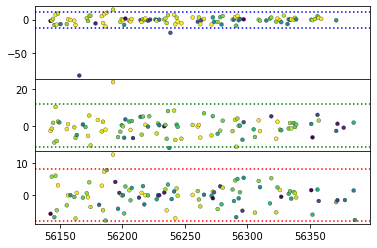

In [95]:
j_diff, h_diff, k_diff = calculate_diffs(dat, sid, verbose=False)

fig, axes = plt.subplots(nrows=3, sharex=True)
fig.subplots_adjust(hspace=0)

j_diff_rms = np.nanstd(_29[0])
j_diff_mean = np.nanmean(_29[0])
j_diff_mad = scipy.stats.median_abs_deviation(_29[0], nan_policy='omit')

h_diff_rms = np.nanstd(_29[1])
h_diff_mean = np.nanmean(_29[1])
h_diff_mad = scipy.stats.median_abs_deviation(_29[1], nan_policy='omit')

k_diff_rms = np.nanstd(_29[2])
k_diff_mean = np.nanmean(_29[2])
k_diff_mad = scipy.stats.median_abs_deviation(_29[2], nan_policy='omit')


plt.sca(axes[0])

plt.scatter(siddat['MEANMJDOBS'], _29[0], c=siddat["JGRADE"], s=15, edgecolor='k', linewidth=0.25)

# plt.axhline(j_diff_mean, color='b')
# plt.axhline(j_diff_rms, color='b')
# plt.axhline(-j_diff_rms, color='b')

plt.axhline(3 * 1.4826*j_diff_mad, color='b', linestyle=':')
plt.axhline(3 * 1.4826*-j_diff_mad, color='b', linestyle=':')

# plt.plot(siddat['MEANMJDOBS'], _29[1], 'g.')

plt.sca(axes[1])

plt.scatter(siddat['MEANMJDOBS'], _29[1], c=siddat["HGRADE"], s=15, edgecolor='k', linewidth=0.25)

plt.axhline(3 * 1.4826*h_diff_mad, color='g', linestyle=':')
plt.axhline(3 * 1.4826*-h_diff_mad, color='g', linestyle=':')
# # plt.axhline(-h_diff_rms, color='g')

plt.sca(axes[2])

plt.scatter(siddat['MEANMJDOBS'], _29[2], c=siddat["KGRADE"], s=15, edgecolor='k', linewidth=0.25)

plt.axhline(3 * 1.4826*k_diff_mad, color='r', linestyle=':')
plt.axhline(3 * 1.4826*-k_diff_mad, color='r', linestyle=':')






SIDD: 44508746107212
Found an outlier! J: -82.719482421875 and 0.9586206674575806
  at date=24.6 (i=19)
Found an outlier! H: -12.2584810256958 and 0.97826087474823
  at date=96.6 (i=76)
Found an outlier! J: -19.561403274536133 and 0.9641255736351013
  at date=97.5 (i=77)



SIDD: 44508746127611
Found an outlier! H: -9.116536140441895 and 0.9739336371421814
  at date=17.6 (i=14)
*** But there are outliers in other bands at that time too. No flag. ***
Found an outlier! K: -8.51267147064209 and 0.9758307933807373
  at date=17.6 (i=14)
*** But there are outliers in other bands at that time too. No flag. ***
Found an outlier! J: -11.162939071655273 and 0.9597315192222595
  at date=97.5 (i=78)
Found an outlier! K: -65.77130889892578 and 0.9603658318519592
  at date=103.4 (i=84)
Found an outlier! J: 7.794283866882324 and 0.9537953734397888
  at date=237.2 (i=163)
Found an outlier! K: -7.635051250457764 and 0.9512194991111755
  at date=244.2 (i=165)



SIDD: 44508746107259
Found an outlier!

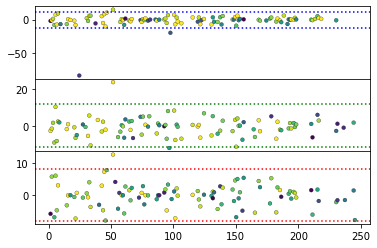

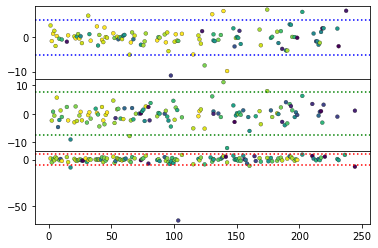

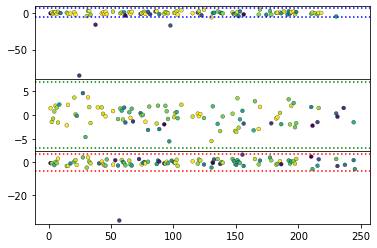

In [110]:
list_of_fun_sids = [sid, sid2, sid3]

for sidd in list_of_fun_sids:
    
    j_diff, h_diff, k_diff = calculate_diffs(dat, sidd, verbose=False)
    
    siddat_ = dat.groups[dat.groups.keys["SOURCEID"] == sidd]


    fig, axes = plt.subplots(nrows=3, sharex=True)
    fig.subplots_adjust(hspace=0)

    j_diff_rms = np.nanstd(j_diff)
    j_diff_mean = np.nanmean(j_diff)
    j_diff_mad = scipy.stats.median_abs_deviation(j_diff, nan_policy='omit')

    h_diff_rms = np.nanstd(h_diff)
    h_diff_mean = np.nanmean(h_diff)
    h_diff_mad = scipy.stats.median_abs_deviation(h_diff, nan_policy='omit')

    k_diff_rms = np.nanstd(k_diff)
    k_diff_mean = np.nanmean(k_diff)
    k_diff_mad = scipy.stats.median_abs_deviation(k_diff, nan_policy='omit')


    plt.sca(axes[0])

    plt.scatter(siddat_['MEANMJDOBS'] - 56141, j_diff, c=siddat_["JGRADE"], s=15, edgecolor='k', linewidth=0.25)

    plt.axhline(3 * 1.4826*j_diff_mad, color='b', linestyle=':')
    plt.axhline(3 * 1.4826*-j_diff_mad, color='b', linestyle=':')

    # plt.plot(siddat['MEANMJDOBS'], _29[1], 'g.')

    plt.sca(axes[1])

    plt.scatter(siddat_['MEANMJDOBS'] - 56141, h_diff, c=siddat_["HGRADE"], s=15, edgecolor='k', linewidth=0.25)

    plt.axhline(3 * 1.4826*h_diff_mad, color='g', linestyle=':')
    plt.axhline(3 * 1.4826*-h_diff_mad, color='g', linestyle=':')

    plt.sca(axes[2])

    plt.scatter(siddat_['MEANMJDOBS'] - 56141, k_diff, c=siddat_["KGRADE"], s=15, edgecolor='k', linewidth=0.25)

    plt.axhline(3 * 1.4826*k_diff_mad, color='r', linestyle=':')
    plt.axhline(3 * 1.4826*-k_diff_mad, color='r', linestyle=':')
    
    k_mad = 1.4826
    bands = ['J', "H", "K"]
    diffs = {"J": j_diff, "H": h_diff, "K": k_diff}
    mads = {"J": j_diff_mad, "H": h_diff_mad, "K": k_diff_mad}
    
    print("\n\n")
    print(f"SIDD: {sidd}")
    
    for i in range(len(j_diff)):

        for b in range(len(bands)):
            b0 = bands[b]   # J, H, K
            b1 = bands[b-1] # K, J, H
            b2 = bands[b-2] # H, K, J

            this_datum = diffs[b0][i]
            this_grade = siddat_[f"{b0}GRADE"][i]
            this_date = siddat_["MEANMJDOBS"][i]

            if (np.abs(this_datum) > 3*k_mad*mads[b0]) and (this_grade < 0.98):
                print(f"Found an outlier! {b0}: {this_datum} and {this_grade}")
                print(f"  at date={this_date-56141:.1f} (i={i})")
    #             print(f"  Found an outlier! {this_datum=} and {this_grade=}")

                if (np.abs(diffs[b1][i]) > 3*k_mad*mads[b1]) or (np.abs(diffs[b2][i]) > 3*k_mad*mads[b2]):
                    print("*** But there are outliers in other bands at that time too. No flag. ***")




J GRADES:  0.0 1.0
H GRADES:  0.0 1.0
K GRADES:  0.0 1.0
J GRADES:  0.0 1.0
H GRADES:  0.0 1.0
K GRADES:  0.0 1.0
J GRADES:  0.0 1.0
H GRADES:  0.0 1.0
K GRADES:  0.0 1.0


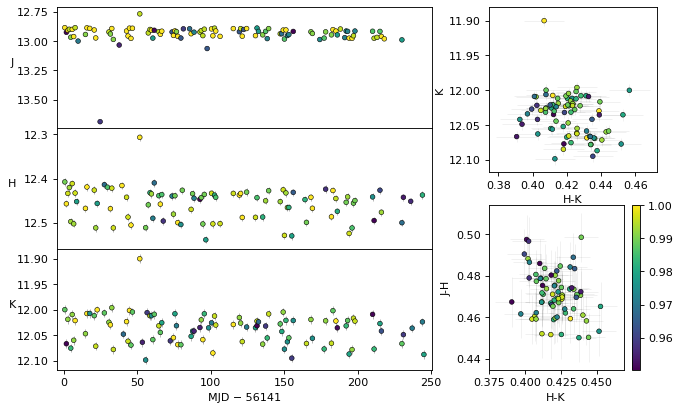

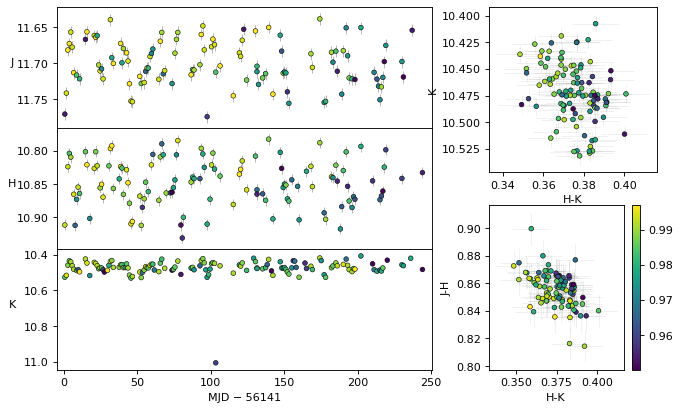

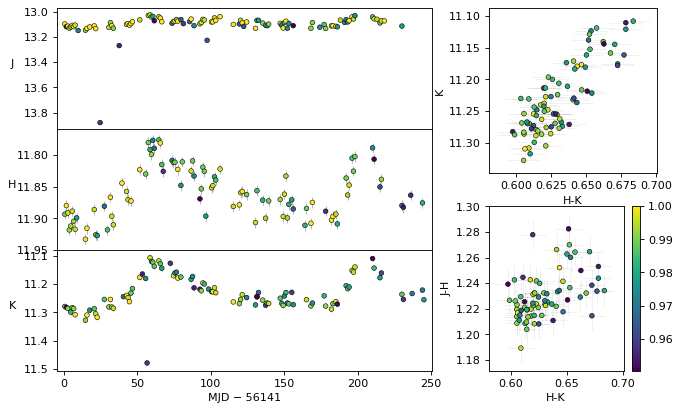

In [100]:
for sidd in list_of_fun_sids:
    simple_lc_scatter_brokenaxes_grade(dat, sidd, date_offset=56141, xlims=[(-5, 251.0)])